<function matplotlib.pyplot.show(close=None, block=None)>

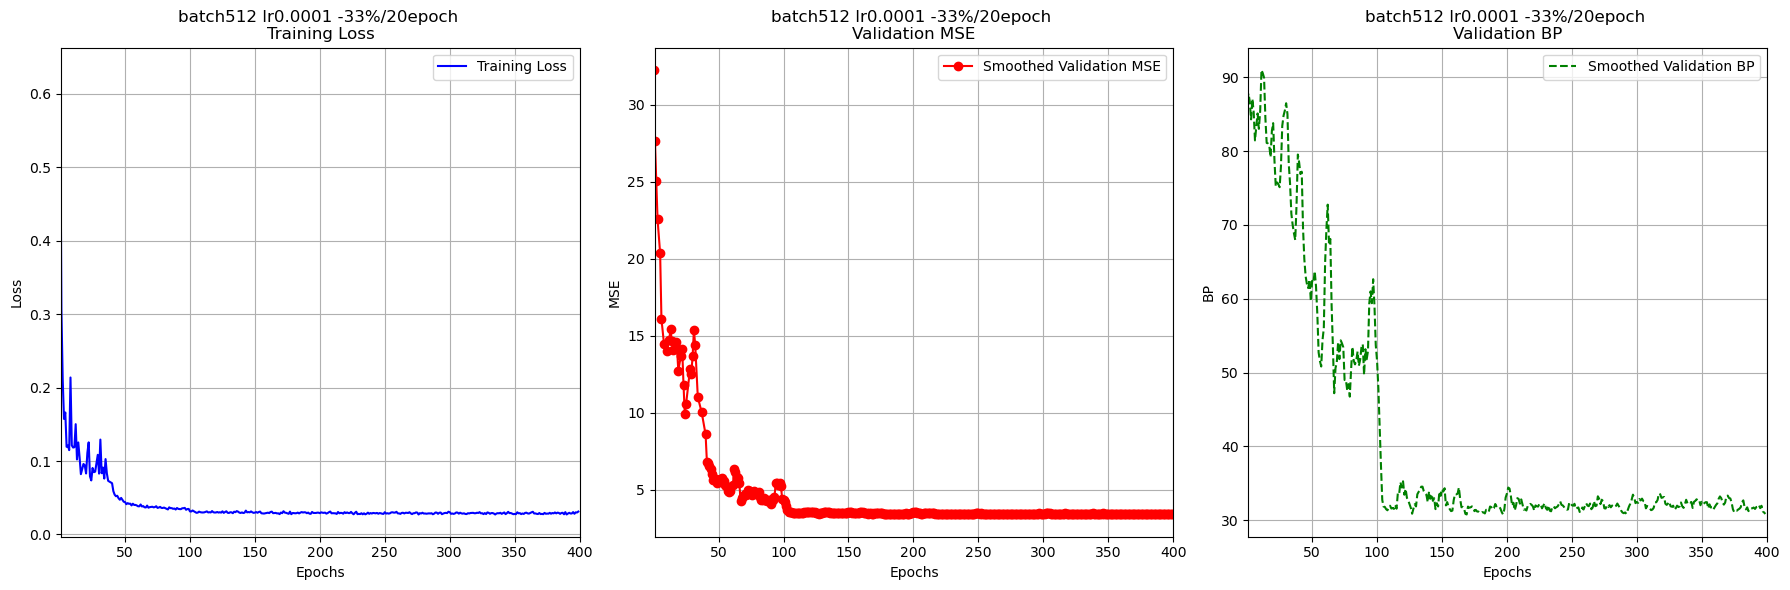

In [1]:
# 学習率スケジューリングの実験　40 100 200で10%までダウン
import re
import matplotlib.pyplot as plt
import pandas as pd

# 移動平均のウィンドウサイズ
window_size_mse = 5  # MSEの移動平均のウィンドウサイズ
window_size_bp = 5   # BPの移動平均のウィンドウサイズ

# ファイルからデータを読み込む関数
def load_data(file_path, regex_pattern, filter_func=None):
    epochs = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(regex_pattern, line)
            if match:
                epoch = int(match.group(1))
                value = float(match.group(2))
                # 除外フィルタがないか、またはフィルタを通過した場合のみデータを追加
                if filter_func is None or filter_func(epoch, value, values):
                    epochs.append(epoch)
                    values.append(value)
    return epochs, values

# 異常値を除外するための関数
def filter_outlier(epoch, value, values):
    if value < 100:  # 100を超えるMSE値を異常とみなし除外
        if len(values) > 0 and value > 2 * values[-1]:  # 前の値の2倍以上であれば除外
            return False
        return True
    return False

# 移動平均を計算する関数
def calculate_moving_average(values, window_size):
    return pd.Series(values).rolling(window=window_size, min_periods=1).mean().tolist()

# 正規表現パターン
pattern_loss = r'Epoch (\d+)/, train Loss: ([0-9.]+)'
pattern_mse = r'Epoch (\d+)/, validation MSE : ([0-9.]+)'
pattern_bp = r'Epoch (\d+)/,.*BP : ([0-9.]+)'

# ファイルからデータを読み込む
epochs_loss, training_loss = load_data('./loss/loss_training_scheduled_lr_0p0001_40_100_200_epoch_90%_down.txt', pattern_loss, filter_outlier)
epochs_mse, validation_mse = load_data('./loss/loss_validation_scheduled_lr_0p0001_40_100_200_epoch_90%_down.txt', pattern_mse, filter_outlier)
epochs_bp, validation_bp = load_data('./loss/loss_validation_scheduled_lr_0p0001_40_100_200_epoch_90%_down.txt', pattern_bp)

# 移動平均の計算
smoothed_mse = calculate_moving_average(validation_mse, window_size_mse)
smoothed_bp = calculate_moving_average(validation_bp, window_size_bp)

# サブプロットを作成
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# トレーニングロスをプロット
ax1.plot(epochs_loss, training_loss, label='Training Loss', color='blue')
ax1.set_title('batch512 lr0.0001 -33%/20epoch \nTraining Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xlim(1, 400)
ax1.legend()
ax1.grid(True)

# 検証MSEをプロット
ax2.plot(epochs_mse, smoothed_mse, label='Smoothed Validation MSE', color='red', marker='o')
ax2.set_title('batch512 lr0.0001 -33%/20epoch \nValidation MSE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')
ax2.set_xlim(1, 400)
ax2.legend()
ax2.grid(True)

# 検証BPをプロット
ax3.plot(epochs_bp, smoothed_bp, label='Smoothed Validation BP', color='green', linestyle='--')
ax3.set_title('batch512 lr0.0001 -33%/20epoch \nValidation BP')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('BP')
ax3.set_xlim(1, 400)
ax3.legend()
ax3.grid(True)

# プロット間のスペースを調整
plt.tight_layout()

# グラフを表示
plt.show


In [33]:
# gifアニメーション　学習率スケジューリングの結果
import imageio.v2 as iio
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImagePalette
import os

# フレームのスピードを計算する関数
# フレームのスピードを計算する関数
def calculate_speed(epoch):
    if epoch < 5:  # エポック1-4はゆっくり
        return 500  # 速度: 500ms (0.5秒)
    elif 5 <= epoch < 10:  # エポック5-9は加速
        # エポック5で400msからエポック9で200msへ線形に減少
        return 500 - ((epoch - 5) * 100)
    elif 10 <= epoch < 190:  # エポック10-29は等速
        return 100  # 速度: 100ms (0.1秒)
    elif 190 <= epoch < 199:  # エポック30-37は減速
        # エポック30で150msからエポック37で450msへ線形に増加
        return 100 + ((epoch - 190) * 50)
    elif epoch == 199:  # エポック38はさらにゆっくり
        return 2000  # 速度: 500ms (0.5秒)
    else:  # エポック39で停止
        return 5000  # 速度: 5000ms (5秒)


# 画像リスト
images = []
durations = []  # 各画像の表示時間を保存するリスト

font_size = 100  # 24ピクセルのサイズでフォントを設定
font_path = "arial.ttf"  # ここに使用したいフォントのパスを指定
font = ImageFont.truetype(font_path, font_size)

# 全画像を処理する
for epoch_num in range(1, 201):
    speed_factor = calculate_speed(epoch_num)
    
    # 画像ファイルのパス
    file_path = f'./validation_output/val_{epoch_num}.png'
    
    if os.path.exists(file_path):
        # 画像を開く
        with Image.open(file_path) as img:
            # テキストを追加する
            draw = ImageDraw.Draw(img)
            # フォント設定 (標準フォントを使用)

            # 左上にエポック数を描画
            if epoch_num != 201:
                draw.text((10, 10), f'epoch={epoch_num}', font=font, fill='white')
            else:
                draw.text((10, 10), f'epoch={epoch_num} best score', font=font, fill='white')

            # 画像をRGBモードに変換して、色を減らす
            img = img.convert('P', colors=256)
            
            # 画像と表示時間をリストに追加する
            images.append(np.array(img))
            durations.append(speed_factor)

# GIFアニメーションを生成
imageio.mimsave('./validation_animation_optimized.gif', images, duration=[d/1000 for d in durations])

print("GIFアニメーションが生成されました。")


GIFアニメーションが生成されました。


<function matplotlib.pyplot.show(close=None, block=None)>

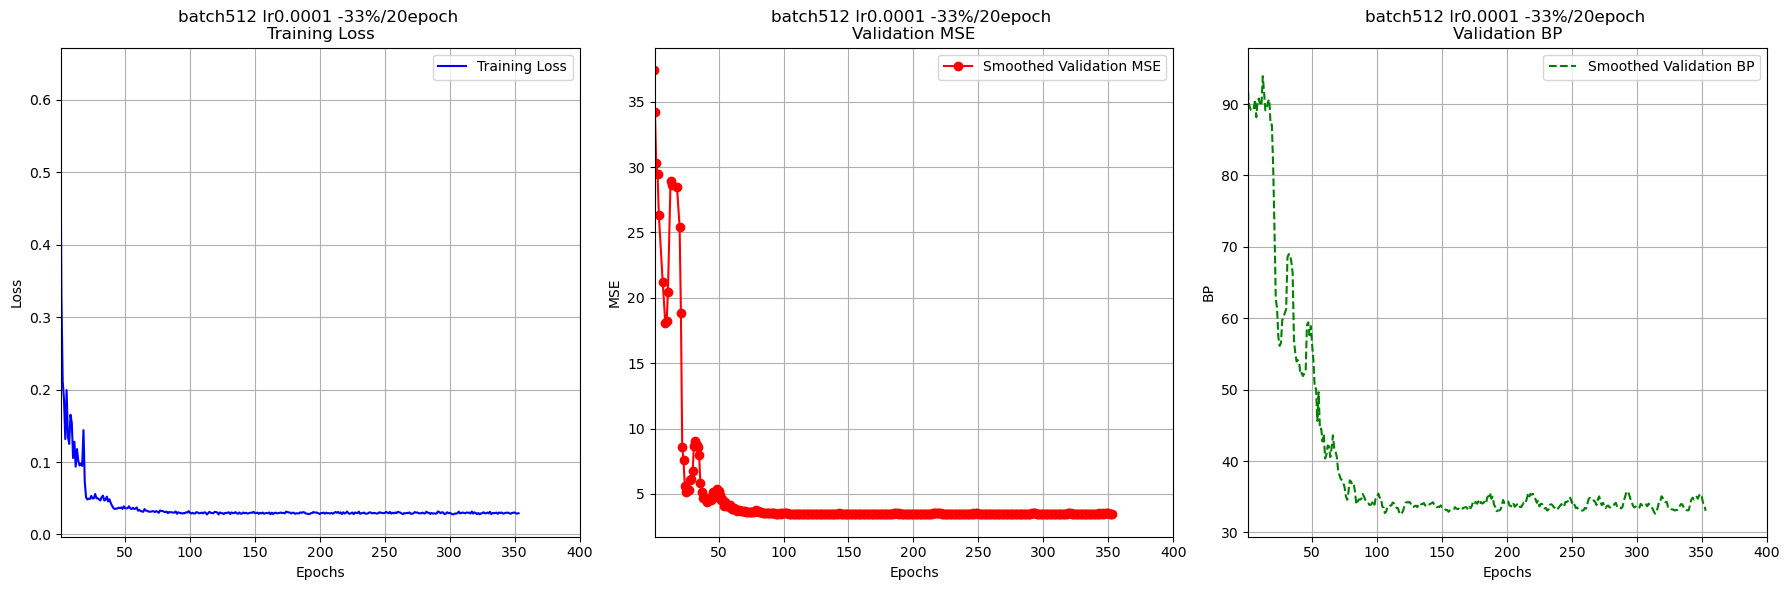

In [31]:
# 学習率スケジューリングの実験　0.0001開始 20epochごとに33%ダウン
import re
import matplotlib.pyplot as plt
import pandas as pd

# 移動平均のウィンドウサイズ
window_size_mse = 5  # MSEの移動平均のウィンドウサイズ
window_size_bp = 5   # BPの移動平均のウィンドウサイズ

# ファイルからデータを読み込む関数
def load_data(file_path, regex_pattern, filter_func=None):
    epochs = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(regex_pattern, line)
            if match:
                epoch = int(match.group(1))
                value = float(match.group(2))
                # 除外フィルタがないか、またはフィルタを通過した場合のみデータを追加
                if filter_func is None or filter_func(epoch, value, values):
                    epochs.append(epoch)
                    values.append(value)
    return epochs, values

# 異常値を除外するための関数
def filter_outlier(epoch, value, values):
    if value < 100:  # 100を超えるMSE値を異常とみなし除外
        if len(values) > 0 and value > 2 * values[-1]:  # 前の値の2倍以上であれば除外
            return False
        return True
    return False

# 移動平均を計算する関数
def calculate_moving_average(values, window_size):
    return pd.Series(values).rolling(window=window_size, min_periods=1).mean().tolist()

# 正規表現パターン
pattern_loss = r'Epoch (\d+)/, train Loss: ([0-9.]+)'
pattern_mse = r'Epoch (\d+)/, validation MSE : ([0-9.]+)'
pattern_bp = r'Epoch (\d+)/,.*BP : ([0-9.]+)'

# ファイルからデータを読み込む
epochs_loss, training_loss = load_data('./loss/loss_training_scheduled_lr_0p0001_every20epoch_33percentDOWN.txt', pattern_loss, filter_outlier)
epochs_mse, validation_mse = load_data('./loss/loss_validation_scheduled_lr_0p0001_every20epoch_33percentDOWN.txt', pattern_mse, filter_outlier)
epochs_bp, validation_bp = load_data('./loss/loss_validation_scheduled_lr_0p0001_every20epoch_33percentDOWN.txt', pattern_bp)

# 移動平均の計算
smoothed_mse = calculate_moving_average(validation_mse, window_size_mse)
smoothed_bp = calculate_moving_average(validation_bp, window_size_bp)

# サブプロットを作成
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# トレーニングロスをプロット
ax1.plot(epochs_loss, training_loss, label='Training Loss', color='blue')
ax1.set_title('batch512 lr0.0001 -33%/20epoch \nTraining Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xlim(1, 400)
ax1.legend()
ax1.grid(True)

# 検証MSEをプロット
ax2.plot(epochs_mse, smoothed_mse, label='Smoothed Validation MSE', color='red', marker='o')
ax2.set_title('batch512 lr0.0001 -33%/20epoch \nValidation MSE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')
ax2.set_xlim(1, 400)
ax2.legend()
ax2.grid(True)

# 検証BPをプロット
ax3.plot(epochs_bp, smoothed_bp, label='Smoothed Validation BP', color='green', linestyle='--')
ax3.set_title('batch512 lr0.0001 -33%/20epoch \nValidation BP')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('BP')
ax3.set_xlim(1, 400)
ax3.legend()
ax3.grid(True)

# プロット間のスペースを調整
plt.tight_layout()

# グラフを表示
plt.show


In [29]:
import imageio.v2 as iio
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImagePalette
import os

# フレームのスピードを計算する関数
# フレームのスピードを計算する関数
def calculate_speed(epoch):
    if epoch < 5:  # エポック1-4はゆっくり
        return 500  # 速度: 500ms (0.5秒)
    elif 5 <= epoch < 10:  # エポック5-9は加速
        # エポック5で400msからエポック9で200msへ線形に減少
        return 500 - ((epoch - 5) * 100)
    elif 10 <= epoch < 30:  # エポック10-29は等速
        return 100  # 速度: 100ms (0.1秒)
    elif 30 <= epoch < 38:  # エポック30-37は減速
        # エポック30で150msからエポック37で450msへ線形に増加
        return 100 + ((epoch - 30) * 50)
    elif epoch == 38:  # エポック38はさらにゆっくり
        return 2000  # 速度: 500ms (0.5秒)
    else:  # エポック39で停止
        return 5000  # 速度: 5000ms (5秒)


# 画像リスト
images = []
durations = []  # 各画像の表示時間を保存するリスト

font_size = 100  # 24ピクセルのサイズでフォントを設定
font_path = "arial.ttf"  # ここに使用したいフォントのパスを指定
font = ImageFont.truetype(font_path, font_size)

# 全画像を処理する
for epoch_num in range(1, 40):
    speed_factor = calculate_speed(epoch_num)
    
    # 画像ファイルのパス
    file_path = f'./validation_output/val_{epoch_num}.png'
    
    if os.path.exists(file_path):
        # 画像を開く
        with Image.open(file_path) as img:
            # テキストを追加する
            draw = ImageDraw.Draw(img)
            # フォント設定 (標準フォントを使用)

            # 左上にエポック数を描画
            if epoch_num != 39:
                draw.text((10, 10), f'epoch={epoch_num}', font=font, fill='white')
            else:
                draw.text((10, 10), f'epoch={epoch_num} best score', font=font, fill='white')

            # 画像をRGBモードに変換して、色を減らす
            img = img.convert('P', colors=256)
            
            # 画像と表示時間をリストに追加する
            images.append(np.array(img))
            durations.append(speed_factor)

# GIFアニメーションを生成
imageio.mimsave('./validation_animation_optimized.gif', images, duration=[d/1000 for d in durations])

print("GIFアニメーションが生成されました。")


GIFアニメーションが生成されました。


In [16]:
import os
import imageio

# 画像のパスを取得
image_folder = './validation_output'
images = []

# 画像ファイル名をソートする（1.png, 2.png, ..., 39.png）
file_names = sorted(os.listdir(image_folder), key=lambda x: int(x.split('_')[1].split('.')[0]))

# フレーム間隔を変更するためのデュレーションを設定する
durations = []

# n=6まで遅く、その後早く、n=35から再び遅くする
for i in range(1, 40):
    if i <= 6:
        duration = 0.5 - (i - 1) * 0.05  # 0.45s to 0.20s
    elif i <= 35:
        duration = 0.2 - (i - 6) * 0.003  # 0.20s to 0.11s
    else:
        duration = 0.11 + (i - 35) * 0.07  # 0.11s to 0.39s
    durations.append(duration)

# 画像ファイルを読み込む
for file_name in file_names:
    if file_name.endswith('.png') and file_name.startswith('val_'):
        file_path = os.path.join(image_folder, file_name)
        images.append(imageio.imread(file_path))

# GIFアニメーションを作成
output_path = './validation_animation.gif'
imageio.mimsave(output_path, images, duration=durations)


C:\Users\ryuta\AppData\Local\Temp\ipykernel_11112\3875290650.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


KeyboardInterrupt: 

In [32]:
# training_lossの２倍以上の点の除去，MSEとBPの移動平均化，epoch400までの表示
import re
import matplotlib.pyplot as plt
import pandas as pd

# 移動平均のウィンドウサイズ
window_size_mse = 5  # MSEの移動平均のウィンドウサイズ
window_size_bp = 5   # BPの移動平均のウィンドウサイズ

# ファイルからデータを読み込む関数
def load_data(file_path, regex_pattern, filter_func=None):
    epochs = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(regex_pattern, line)
            if match:
                epoch = int(match.group(1))
                value = float(match.group(2))
                # 除外フィルタがないか、またはフィルタを通過した場合のみデータを追加
                if filter_func is None or filter_func(epoch, value, values):
                    epochs.append(epoch)
                    values.append(value)
    return epochs, values

# 異常値を除外するための関数
def filter_outlier(epoch, value, values):
    if value < 100:  # 100を超えるMSE値を異常とみなし除外
        if len(values) > 0 and value > 2 * values[-1]:  # 前の値の2倍以上であれば除外
            return False
        return True
    return False

# 移動平均を計算する関数
def calculate_moving_average(values, window_size):
    return pd.Series(values).rolling(window=window_size, min_periods=1).mean().tolist()

# 正規表現パターン
pattern_loss = r'Epoch (\d+)/, train Loss: ([0-9.]+)'
pattern_mse = r'Epoch (\d+)/, validation MSE : ([0-9.]+)'
pattern_bp = r'Epoch (\d+)/,.*BP : ([0-9.]+)'

# ファイルからデータを読み込む
epochs_loss, training_loss = load_data('./loss/loss_training.txt', pattern_loss, filter_outlier)
epochs_mse, validation_mse = load_data('./loss/loss_validation.txt', pattern_mse, filter_outlier)
epochs_bp, validation_bp = load_data('./loss/loss_validation.txt', pattern_bp)

# 移動平均の計算
smoothed_mse = calculate_moving_average(validation_mse, window_size_mse)
smoothed_bp = calculate_moving_average(validation_bp, window_size_bp)

# サブプロットを作成
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# トレーニングロスをプロット
ax1.plot(epochs_loss, training_loss, label='Training Loss', color='blue')
ax1.set_title('batch512 lr0.0001\nTraining Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xlim(1, 400)
ax1.legend()
ax1.grid(True)

# 検証MSEをプロット
ax2.plot(epochs_mse, smoothed_mse, label='Smoothed Validation MSE', color='red', marker='o')
ax2.set_title('batch512 lr0.0001\nValidation MSE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')
ax2.set_xlim(1, 400)
ax2.legend()
ax2.grid(True)

# 検証BPをプロット
ax3.plot(epochs_bp, smoothed_bp, label='Smoothed Validation BP', color='green', linestyle='--')
ax3.set_title('batch512 lr0.0001\nValidation BP')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('BP')
ax3.set_xlim(1, 400)
ax3.legend()
ax3.grid(True)

# プロット間のスペースを調整
plt.tight_layout()

# グラフを表示
plt.show


FileNotFoundError: [Errno 2] No such file or directory: './loss/loss_training.txt'

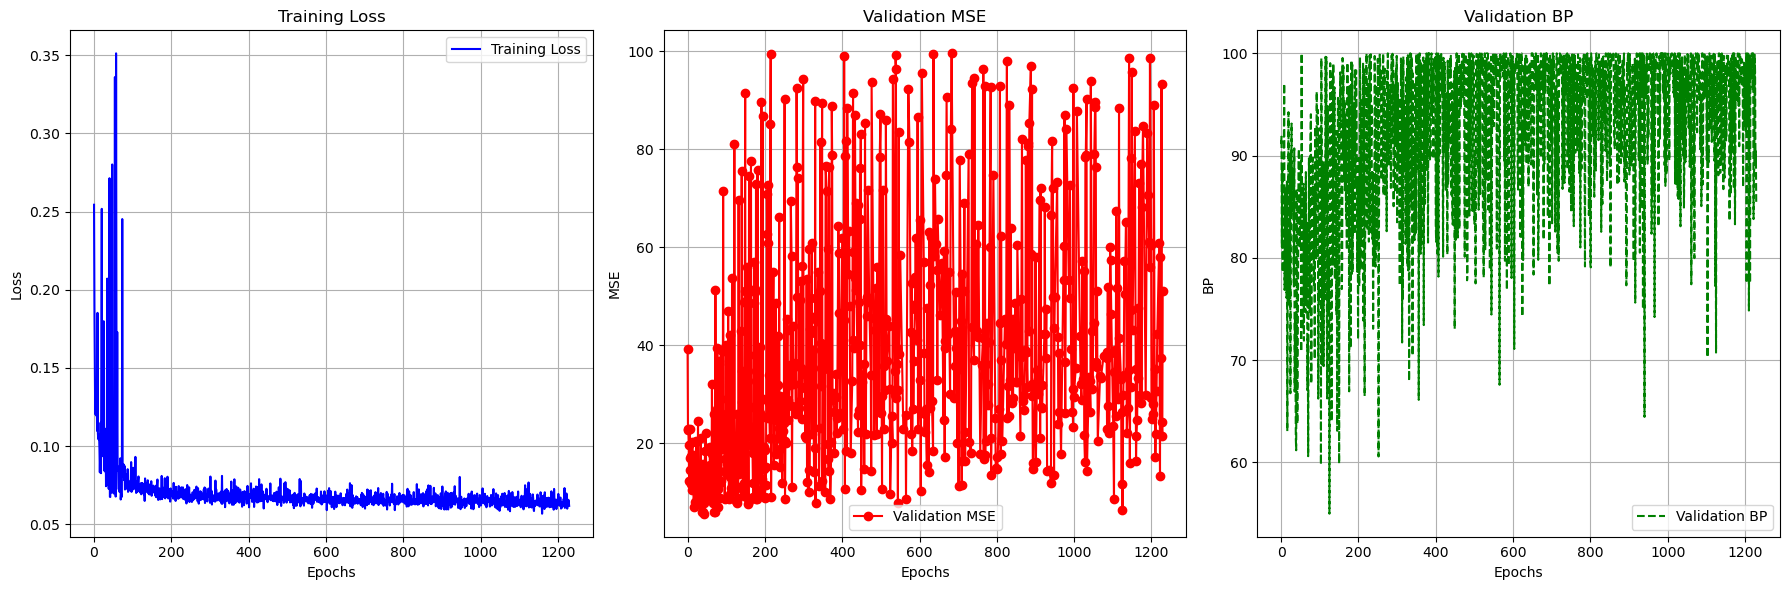

In [4]:
# 1200epoch batch512 lr0.001 グラフ処理MSE>100除外

import re
import matplotlib.pyplot as plt

# ファイルからデータを読み込む関数
def load_data(file_path, regex_pattern, filter_func=None):
    epochs = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(regex_pattern, line)
            if match:
                epoch = int(match.group(1))
                value = float(match.group(2))
                if filter_func is None or filter_func(value):
                    epochs.append(epoch)
                    values.append(value)
    return epochs, values

# 異常値を除外するための関数
def filter_mse(value):
    return value < 100  # 100を超えるMSE値を異常とみなし除外

# 正規表現パターン
pattern_loss = r'Epoch (\d+)/, train Loss: ([0-9.]+)'
pattern_mse = r'Epoch (\d+)/, validation MSE : ([0-9.]+)'
pattern_bp = r'Epoch (\d+)/,.*BP : ([0-9.]+)'

# ファイルからデータを読み込む
epochs_loss, training_loss = load_data('./loss/loss_training.txt', pattern_loss)
epochs_mse, validation_mse = load_data('./loss/loss_validation.txt', pattern_mse, filter_mse)
epochs_bp, validation_bp = load_data('./loss/loss_validation.txt', pattern_bp)

# サブプロットを作成
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))  # 3つのサブプロットを横に並べる

# トレーニングロスをプロット
ax1.plot(epochs_loss, training_loss, label='Training Loss', color='blue')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# 検証MSEをプロット
ax2.plot(epochs_mse, validation_mse, label='Validation MSE', color='red', marker='o')
ax2.set_title('Validation MSE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')
ax2.legend()
ax2.grid(True)

# 検証BPをプロット
ax3.plot(epochs_bp, validation_bp, label='Validation BP', color='green', linestyle='--')
ax3.set_title('Validation BP')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('BP')
ax3.legend()
ax3.grid(True)

# プロット間のスペースを調整
plt.tight_layout()

# グラフを表示
plt.show()


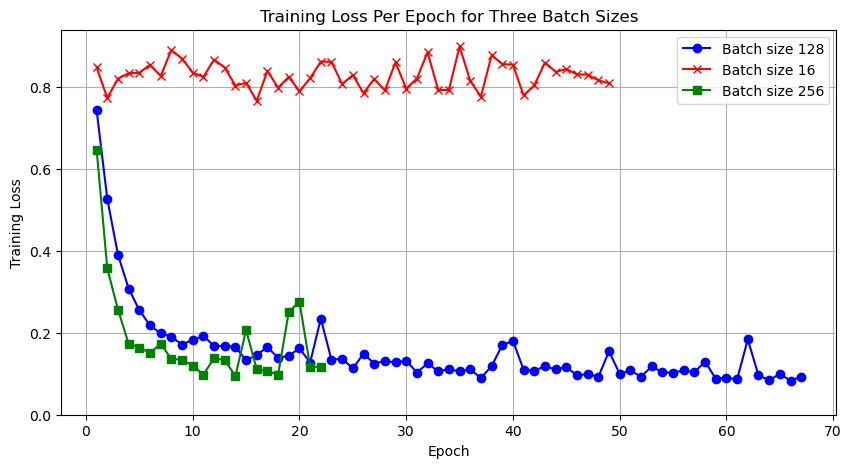

In [2]:
#バッチサイズを大きくしたら学習が進んだという比較プロット
import matplotlib.pyplot as plt

# 最初の損失値のリスト（完全なデータ）
loss_values_1 = [
    0.7434232804179192, 0.5273751699924469, 0.3907719227671623, 0.3082914386689663,
    0.25558364428579805, 0.21837490864098072, 0.19867589712142944, 0.1909205824136734,
    0.1713011809065938, 0.1828540514782071, 0.1926101664453745, 0.16814015209674835,
    0.16775246545672418, 0.16609604440629483, 0.13272763427346945, 0.14630633167922497,
    0.16504884947091342, 0.13879863861948252, 0.14432156629860401, 0.16204523723572492,
    0.1273815378546715, 0.23463605668395757, 0.13423598296940326, 0.13695023041218518,
    0.11325230292975902, 0.14894496310502292, 0.12515490856021644, 0.13139629177749157,
    0.12775965796783567, 0.13240353789180517, 0.10306236416101455, 0.12536624494940043,
    0.10614080000668764, 0.11118259649723768, 0.10570380443707109, 0.11076479412615299,
    0.08955305797979235, 0.11876976208761335, 0.169978253133595, 0.18055788211524487,
    0.10980396836996079, 0.1074127484112978, 0.1185672102868557, 0.11061949659138919,
    0.11629835035651923, 0.09614240875467658, 0.09973744831979275, 0.09255804037675261,
    0.15499978430569172, 0.09965834263712167, 0.10832687493413687, 0.0928300953283906,
    0.11805313240736723, 0.10352233812212944, 0.10292248737066984, 0.10809067375957966,
    0.10418498165905475, 0.12956925760954618, 0.0881113583035767, 0.09023220928385854,
    0.08687727697193623, 0.18391606882214545, 0.09625758543610573, 0.08446979217231274,
    0.0995772972330451, 0.08330440141260624, 0.09304065374657512
]


# 新しい損失値のリスト（完全なデータ）
loss_values_2 = [
    0.8486959637701511, 0.7738938124477863, 0.8211718466877937, 0.8344736585021019,
    0.835596367418766, 0.8550813582539558, 0.8275318740308285, 0.8910514375567437,
    0.8703472577035427, 0.835949798822403, 0.8252442429959774, 0.8677499762177467,
    0.8482441785931587, 0.8041250422596932, 0.8110737781226635, 0.7670845054090023,
    0.8400445149838924, 0.7991737398505211, 0.8257007113099099, 0.7903095830976963,
    0.8222879901528358, 0.862934937030077, 0.8623684419691563, 0.8080002048611641,
    0.829993449151516, 0.7856664901971817, 0.8203941404819488, 0.7924657019972802,
    0.8610088036954403, 0.7970242823660374, 0.8212532402575016, 0.8855875641107559,
    0.7935412840545177, 0.7935434432327747, 0.899883029460907, 0.8157495938241481,
    0.7770353914797306, 0.8784691697359085, 0.8570007930696011, 0.8550544114410877,
    0.7803154355287552, 0.8048581786453723, 0.8605333481729031, 0.8378045682609081,
    0.8445911553502082, 0.8316792005300522, 0.83112449452281, 0.8172638985514641,
    0.8096240366995334
]

loss_values_3 = [
    0.6477448099851608, 0.35730346232652666, 0.25674377351999284, 0.173320132791996,
    0.16400158837437628, 0.15091657258570193, 0.1739681002125144, 0.13588139832019805,
    0.13490774612873793, 0.12009203769266605, 0.09821617972105741, 0.1377579789608717,
    0.13355833321809768, 0.09449351698160172, 0.20675134014338256, 0.11075961869210005,
    0.10668226875364781, 0.09785264264792204, 0.2514144477620721, 0.2760098394751549,
    0.11703652761876583, 0.11674131277948618
]
epochs = list(range(1, max(len(loss_values_1), len(loss_values_2), len(loss_values_3))+1))

# 損失値のプロット
plt.figure(figsize=(10,5))
plt.plot(epochs[:len(loss_values_1)], loss_values_1, marker='o', linestyle='-', color='blue', label='Batch size 128')
plt.plot(epochs[:len(loss_values_2)], loss_values_2, marker='x', linestyle='-', color='red', label='Batch size 16')
# loss_values_3をプロットに追加します。
plt.plot(epochs[:len(loss_values_3)], loss_values_3, marker='s', linestyle='-', color='green', label='Batch size 512') # 例としてバッチサイズ256を追加

# タイトルと軸ラベルの設定
plt.title('Training Loss Per Epoch for Three Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# y軸の範囲を設定（オプション）
plt.ylim(ymin=0)

# グラフを表示
plt.show()
